In [397]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [398]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [399]:
hdf_dir = Path("../data")

In [400]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [676]:
fname = "2021_4_20.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1618952662 scan R0 F1 1_2 F 1                                                    : 1
1  <> 1618952737 scan R0 F1 1_2 F 1                                                    : 681
2  <> 1618953129 scan R0 F1 1_2 F 1 broad scan                                         : 56
3  <> 1618953314 scan R0 F1 1_2 F 1 broad scan                                         : 1891
4  <> 1618954724 scan without signal                                                   : 1801
5  <> 1618960757 scan without signal pmt off                                           : 3601
6  <> 1618962148 scan without signal pmt on                                            : 3601
7  <> 1618964400 scan without signal pmt on                                            : 7201
8  <> 1618968827 scan with RC and DET lasers on                                        : 13601
9  <> 1618970913 scan with RC and DET lasers on and microwaves on                      : 5853


## Scan R0 F1

In [702]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [703]:
dset_idx = 1
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

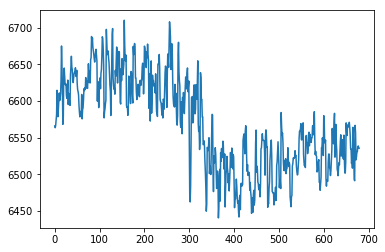

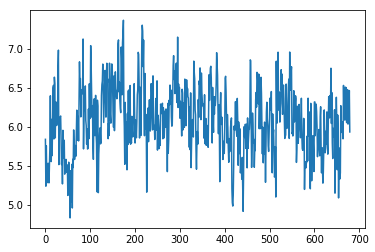

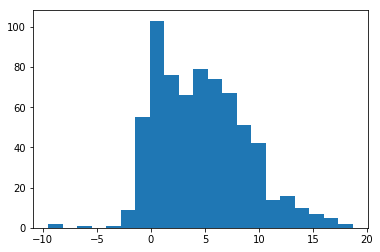

In [704]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [705]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 3
fl_cutoff = -5000

In [706]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

55.1% data discarded


In [707]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

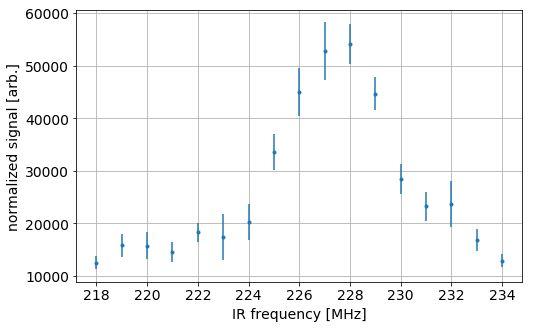

In [708]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

0.7231712981072143
<Parameter 'center', value=227.42397564083623 +/- 0.108, bounds=[-inf:inf]>
<Parameter 'fwhm', value=4.586575596174486 +/- 0.212, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=11946.6467035852 +/- 754, bounds=[-inf:inf]>


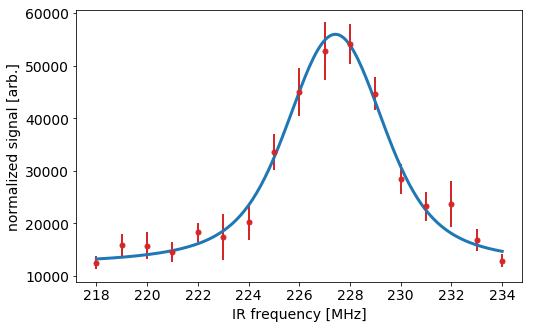

In [710]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

## Scan R0 F1
larger scan range

In [14]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [15]:
dset_idx = 3
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

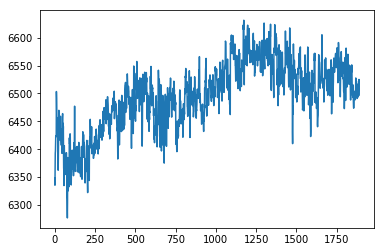

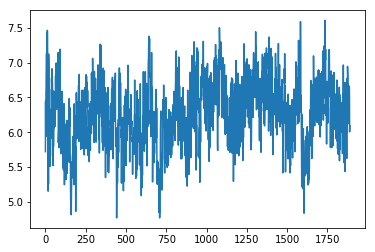

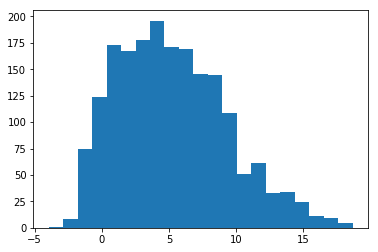

In [16]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [17]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 3
fl_cutoff = -100000

In [18]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

40.6% data discarded


In [19]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

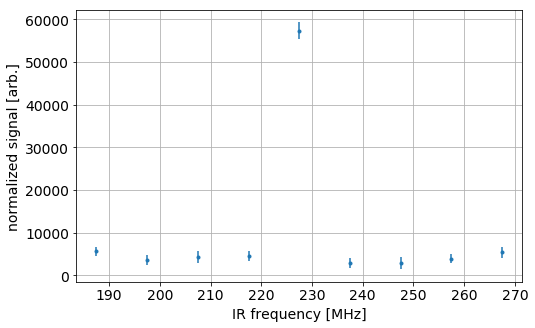

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

1.0505625987364813
<Parameter 'center', value=227.4960118306693 +/- 325, bounds=[-inf:inf]>
<Parameter 'fwhm', value=0.005329632978159784 +/- 0, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=4207.112529442697 +/- 596, bounds=[-inf:inf]>


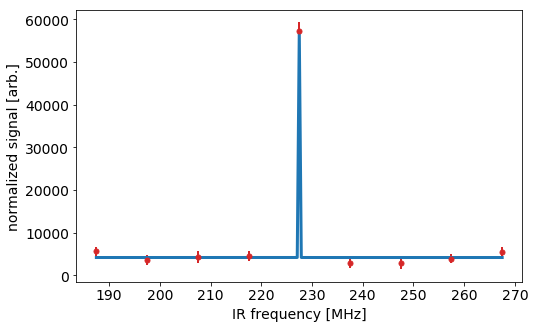

In [21]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
result.params['center']
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

In [22]:
def fun(a,b, offset):
    return (a+offset)/(b+offset)

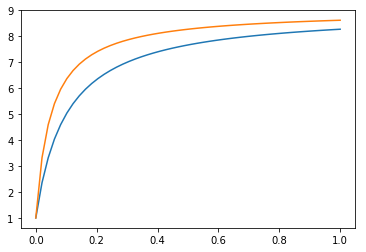

In [23]:
gain = 9
a = np.linspace(0,1)*gain
b = a.copy()/gain

plt.plot(b, fun(a,b,0.1))
plt.plot(b, fun(a,b,0.05))

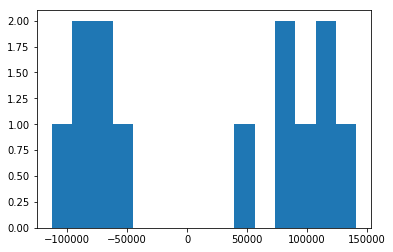

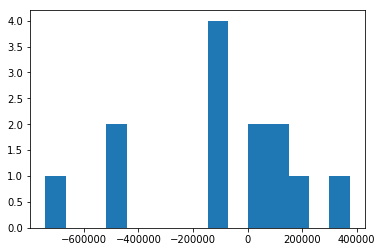

In [24]:
d = pmt_data[mask_yag] - np.mean(pmt_data[mask_yag][:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)
plt.hist(d, bins = 15);

d1 = norm_data[mask_yag] - np.mean(norm_data[mask_yag][:,-3000:], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)
plt.figure()
plt.hist(d/d1, bins = 15);

In [25]:
np.mean(d)

16094.222256410214

In [26]:
np.mean(d/d1)

-89060.41832817203

In [27]:
d/d1

array([  32286.06406916,  106462.76486012,   77322.96769389,
       -105258.92258239, -740855.07130959,  -87486.90223584,
       -102997.95012162,  -72788.54626488, -448144.54083943,
        374637.02719795,  200170.06430787,   54909.08528736,
       -446041.47832885])

## Scan without beam or YAG firing
larger scan range

In [28]:
slice_flm  = np.s_[-2000:]
slice_absm = np.s_[-2000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [29]:
dset_idx = 4
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

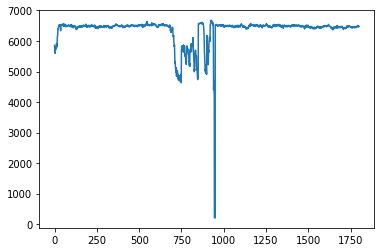

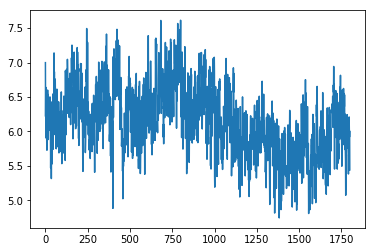

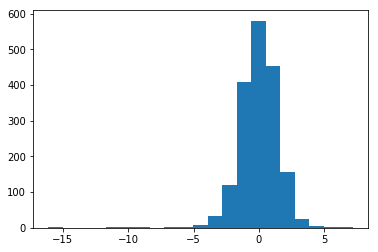

In [30]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [31]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 3
fl_cutoff = -100000

In [32]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_pdn

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

12.2% data discarded


In [33]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

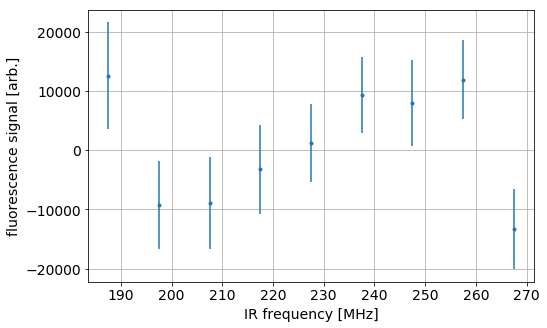

In [34]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('fluorescence signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [35]:
def fun(a,b, offset):
    return (a+offset)/(b+offset)

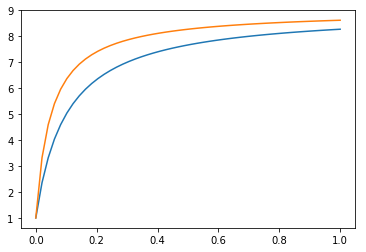

In [36]:
gain = 9
a = np.linspace(0,1)*gain
b = a.copy()/gain

plt.plot(b, fun(a,b,0.1))
plt.plot(b, fun(a,b,0.05))

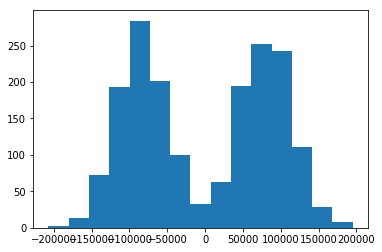

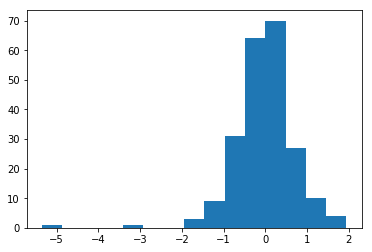

In [37]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)
plt.hist(d, bins = 15);

d1 = norm_data[mask] - np.mean(norm_data[mask][:,:3000], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)
plt.figure()
plt.hist(d1, bins = 15);

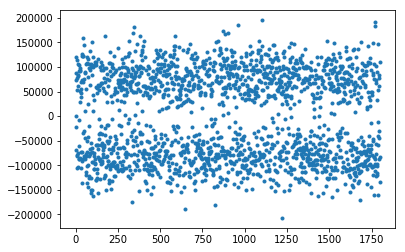

In [38]:
plt.plot(d, '.')

(array([  3.,  14.,  72., 192., 283., 203., 100.,  33.,  63., 195., 253.,
        240., 112.,  28.,   9.]),
 array([-35.38707692, -30.80620855, -26.22534017, -21.64447179,
        -17.06360342, -12.48273504,  -7.90186667,  -3.32099829,
          1.25987009,   5.84073846,  10.42160684,  15.00247521,
         19.58334359,  24.16421197,  28.74508034,  33.32594872]),
 <a list of 15 Patch objects>)

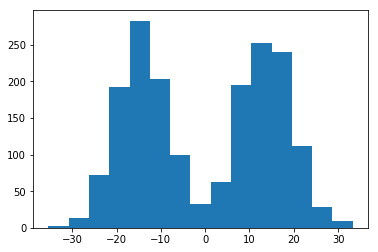

In [39]:
plt.hist((pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis])[:,150:].mean(axis = 1), bins = 15)

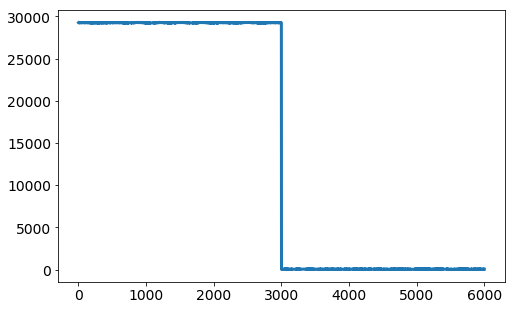

In [46]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(shutter_data[0], lw = 3)
set_fontsize(ax, 14)

The shutter was closing half-way in a trace, which is connected also to the PXIe DAQ, generating an offset on the PMT channel at [3000:] w.r.t [:3000], which causes the double peaks 

## Scan without beam or YAG firing
larger scan range  
PMT off

In [164]:
slice_flm  = np.s_[-2000:]
slice_absm = np.s_[-2000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [165]:
dset_idx = 5
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

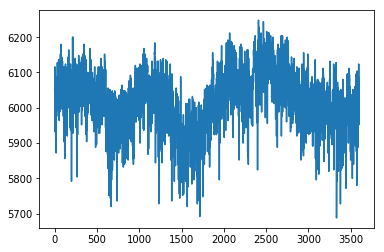

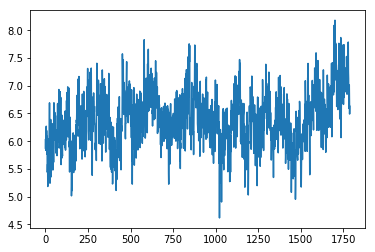

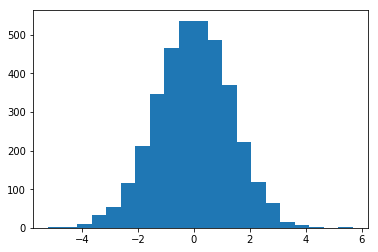

In [166]:
plt.plot(pdn_data.min(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [167]:
yag_cutoff = 250
ptn_cutoff = 5500
abs_cutoff = 3
fl_cutoff = -100000

In [168]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_pdn

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.0% data discarded


In [169]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

traces = []
stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    traces.append(pmt_data_norm[mt])
    dat = (fluorescence_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
traces = traces
bin_means = np.unique(scan_parameters)

197.5 MHz
mean = 379 +/- 616
nr shots = 400


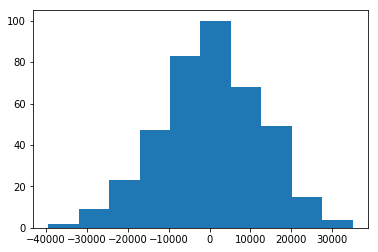

In [170]:
idx = 1
plt.hist(np.trapz(traces[idx][:, slice_fli], axis = 1));
print(f"{bin_means[idx]} MHz")
print(f"mean = {np.trapz(traces[idx][:, slice_fli], axis = 1).mean():.0f} +/- {np.trapz(traces[idx][:, slice_fli], axis = 1).std()/np.sqrt(len(traces[idx])-1):.0f}")
print(f"nr shots = {len(traces[idx])}")

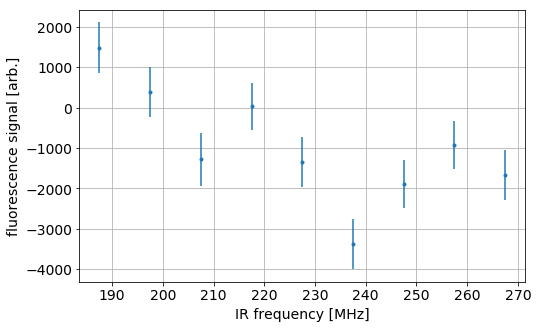

In [171]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('fluorescence signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

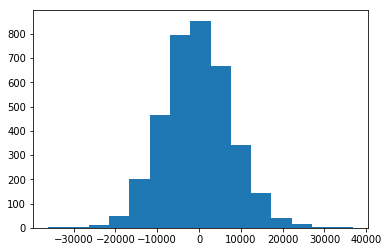

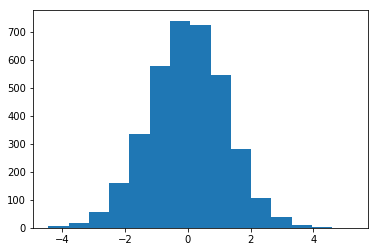

In [172]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)
plt.hist(d, bins = 15);

d1 = norm_data - np.mean(norm_data[:,-3000:], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)
plt.figure()
plt.hist(d1, bins = 15);

## Scan without beam or YAG firing
larger scan range  
PMT on  
DET on

In [540]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [541]:
dset_idx = 6
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

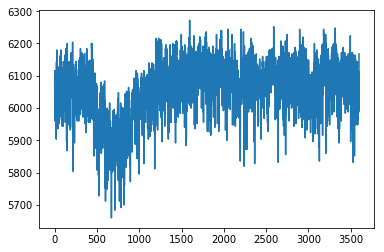

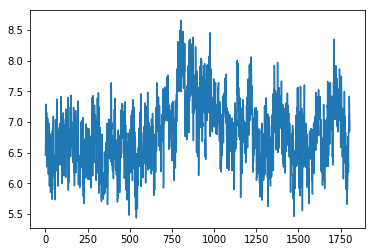

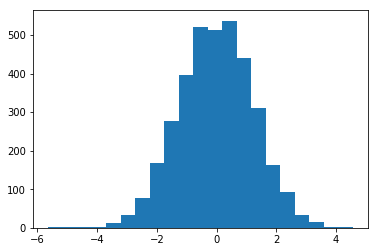

In [542]:
plt.plot(pdn_data.min(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [543]:
yag_cutoff = 250
ptn_cutoff = 5500
abs_cutoff = 3
fl_cutoff = -100000

In [544]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_pdn

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.0% data discarded


In [545]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

traces = []
stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    traces.append(pmt_data_norm[mt])
    dat = (fluorescence_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
traces = traces
bin_means = np.unique(scan_parameters)

197.5 MHz
mean = 1216 +/- 1661
nr shots = 400


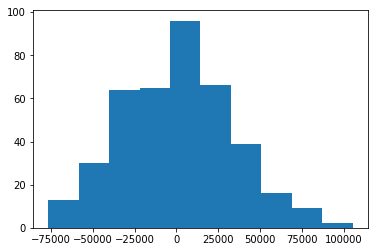

In [546]:
idx = 1
plt.hist(np.trapz(traces[idx][:, slice_fli], axis = 1));
print(f"{bin_means[idx]} MHz")
print(f"mean = {np.trapz(traces[idx][:, slice_fli], axis = 1).mean():.0f} +/- {np.trapz(traces[idx][:, slice_fli], axis = 1).std()/np.sqrt(len(traces[idx])-1):.0f}")
print(f"nr shots = {len(traces[idx])}")

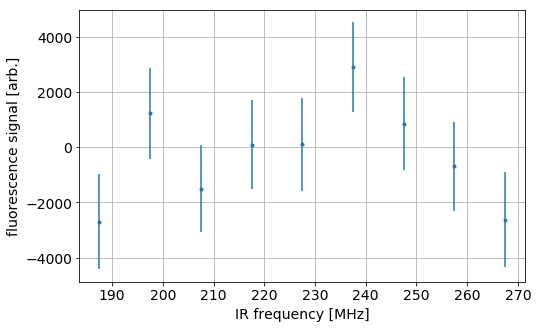

In [547]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('fluorescence signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

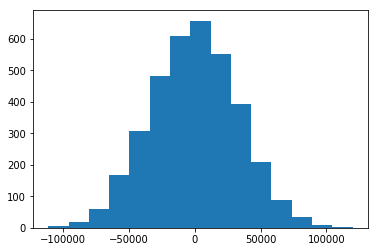

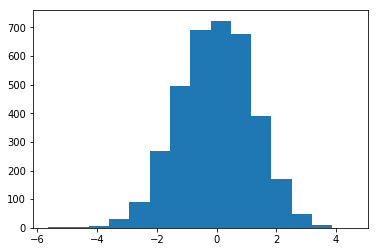

In [548]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)
plt.hist(d, bins = 15);

d1 = norm_data - np.mean(norm_data[:,-3000:], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)
plt.figure()
plt.hist(d1, bins = 15);

In [549]:
def fun(a,b, offset):
    return (a+offset)/(b+offset)

In [552]:
# previously we had on resonance an integrated signal of about 6e5 (normalized with absorption), with an integrated absorption signal around 5
gain = 9
b = 6e5*5
a = b*gain

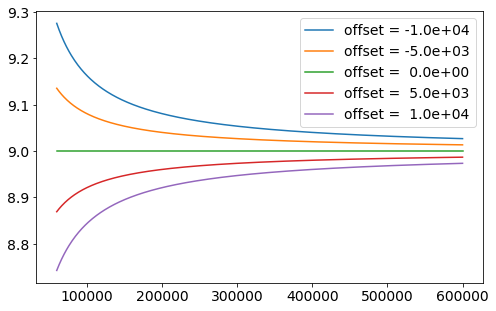

In [553]:
scal = np.linspace(0.1,1,501)

fig, ax = plt.subplots(figsize = (8,5))

for offset in np.linspace(-1e4,1e4,5):
    vals = fun(a*scal, b*scal, offset)
    ax.plot(b*scal/5, vals, label = f'offset = {offset:>8.1e}')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [556]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 
fake_data = pmt_data + (gaussian(_x,1000,800,150)*gain[:,np.newaxis])
fake_data_norm = fake_data - np.mean(fake_data[:,slice_flm], axis = 1)[:,np.newaxis]

In [557]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

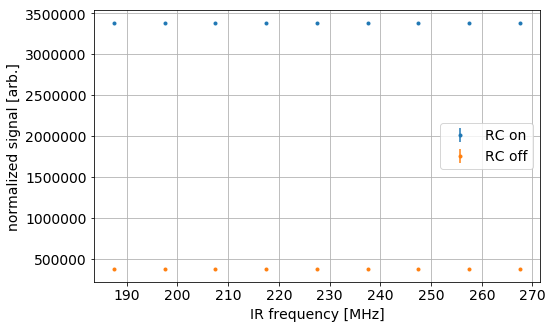

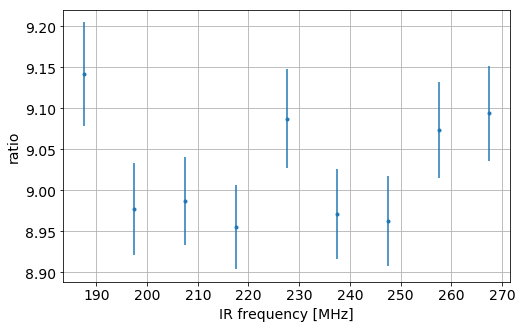

In [558]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan without beam or YAG firing
larger scan range  
PMT on  
DET on

In [559]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [560]:
dset_idx = 7
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

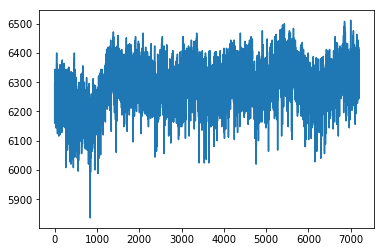

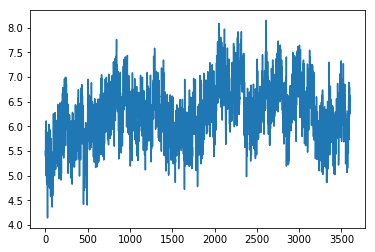

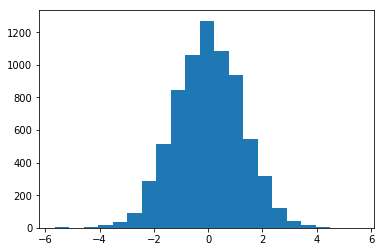

In [561]:
plt.plot(pdn_data.min(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [562]:
yag_cutoff = 250
ptn_cutoff = 5500
abs_cutoff = 3
fl_cutoff = -100000

In [563]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_pdn

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.0% data discarded


In [564]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

traces = []
stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    traces.append(pmt_data_norm[mt])
    dat = (fluorescence_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
traces = traces
bin_means = np.unique(scan_parameters)

197.5 MHz
mean = 55 +/- 1181
nr shots = 800


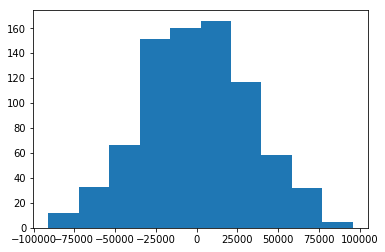

In [565]:
idx = 1
plt.hist(np.trapz(traces[idx][:, slice_fli], axis = 1));
print(f"{bin_means[idx]} MHz")
print(f"mean = {np.trapz(traces[idx][:, slice_fli], axis = 1).mean():.0f} +/- {np.trapz(traces[idx][:, slice_fli], axis = 1).std()/np.sqrt(len(traces[idx])-1):.0f}")
print(f"nr shots = {len(traces[idx])}")

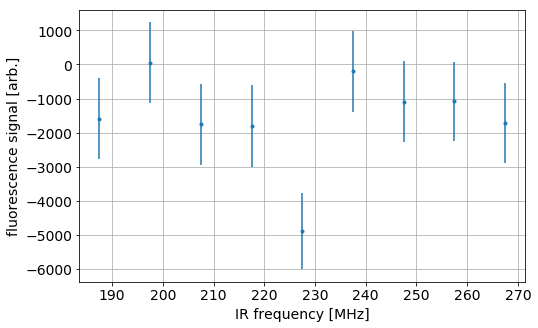

In [566]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('fluorescence signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

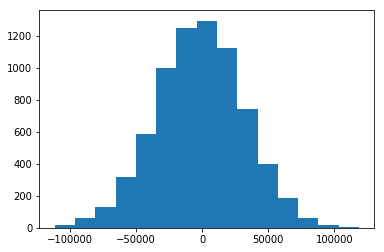

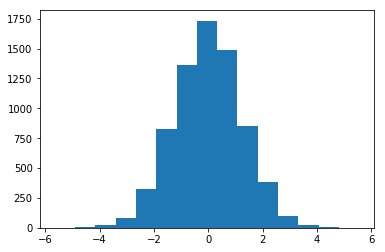

In [567]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)
plt.hist(d, bins = 15);

d1 = norm_data - np.mean(norm_data[:,-3000:], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)
plt.figure()
plt.hist(d1, bins = 15);

In [568]:
def fun(a,b, offset):
    return (a+offset)/(b+offset)

In [569]:
# previously we had on resonance an integrated signal of about 6e5 (normalized with absorption), with an integrated absorption signal around 5
gain = 9
b = 6e5*5
a = b*gain

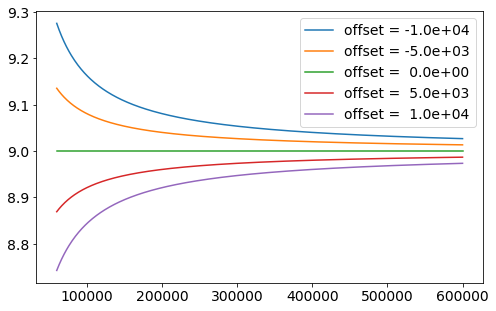

In [570]:
scal = np.linspace(0.1,1,501)

fig, ax = plt.subplots(figsize = (8,5))

for offset in np.linspace(-1e4,1e4,5):
    vals = fun(a*scal, b*scal, offset)
    ax.plot(b*scal/5, vals, label = f'offset = {offset:>8.1e}')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [628]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
# mask_sh_open = np.ones(len(shutter_data), dtype = bool)
# mask_sh_open[::2] = False
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 

for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    gain[mask_frequency] *= gaussian(f, 1, 227.5, 20)

fake_data = pmt_data.copy()
fake_data_norm = fake_data - np.mean(fake_data[:,-3000:], axis = 1)[:,np.newaxis]
fake_data_norm = fake_data_norm + (gaussian(_x,1000,800,150)*gain[:,np.newaxis])

In [629]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

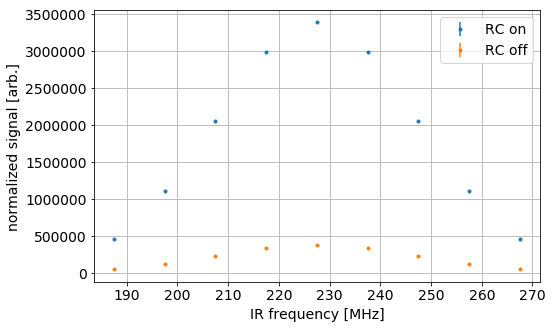

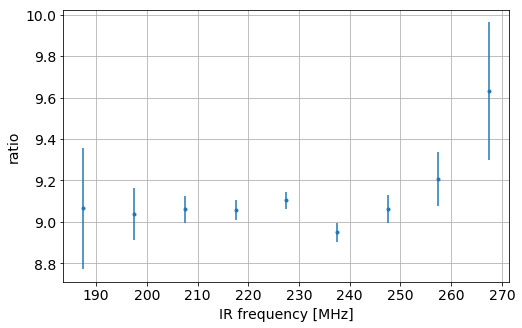

In [630]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [620]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
# mask_sh_open = np.ones(len(shutter_data), dtype = bool)
# mask_sh_open[::2] = False
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 

fake_data = pmt_data + (gaussian(_x,2000,800,150)*gain[:,np.newaxis])
fake_data_norm = fake_data - np.mean(fake_data[:,slice_flm], axis = 1)[:,np.newaxis]

In [614]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

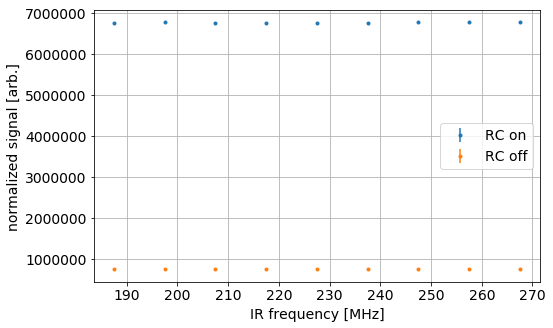

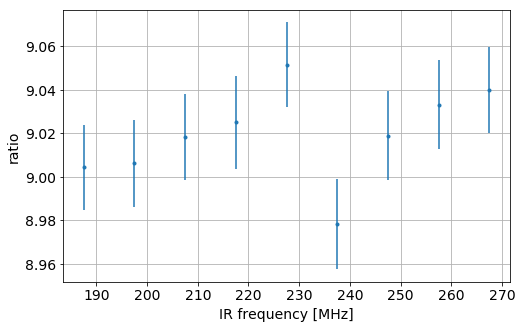

In [615]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan without beam or YAG firing
larger scan range  
PMT on  
RC and DET on

In [636]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [637]:
dset_idx = 8
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

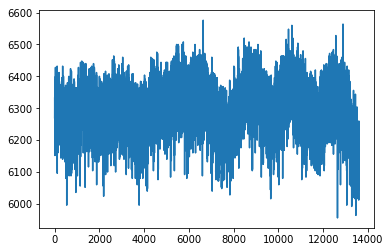

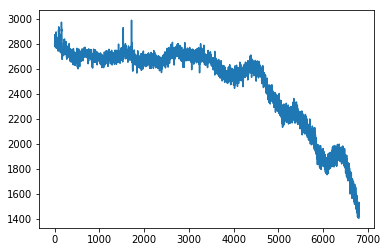

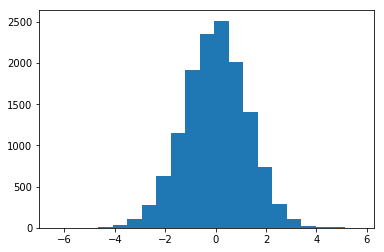

In [638]:
plt.plot(pdn_data.min(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [639]:
yag_cutoff = 250
ptn_cutoff = 5500
abs_cutoff = 3
fl_cutoff = -100000

In [640]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_pdn

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.0% data discarded


In [641]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

traces = []
stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    traces.append(pmt_data_norm[mt])
    dat = (fluorescence_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
traces = traces
bin_means = np.unique(scan_parameters)

224.0 MHz
mean = -833 +/- 1141
nr shots = 800


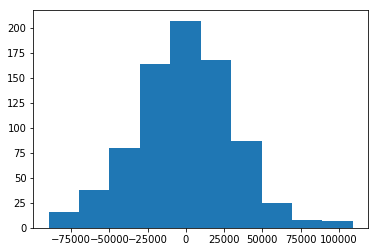

In [642]:
idx = 1
plt.hist(np.trapz(traces[idx][:, slice_fli], axis = 1));
print(f"{bin_means[idx]} MHz")
print(f"mean = {np.trapz(traces[idx][:, slice_fli], axis = 1).mean():.0f} +/- {np.trapz(traces[idx][:, slice_fli], axis = 1).std()/np.sqrt(len(traces[idx])-1):.0f}")
print(f"nr shots = {len(traces[idx])}")

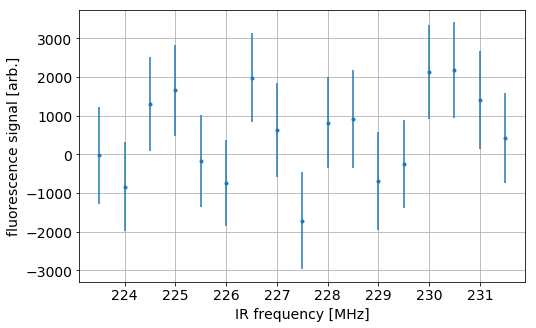

In [643]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('fluorescence signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [ ]:
mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

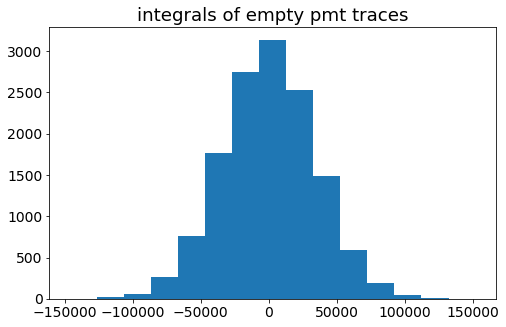

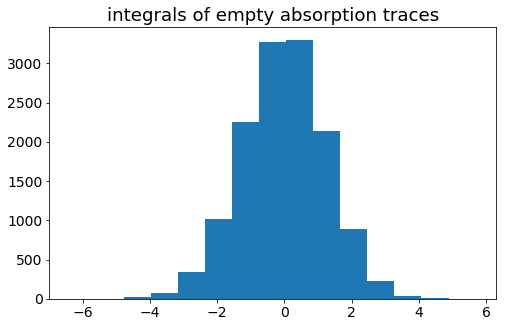

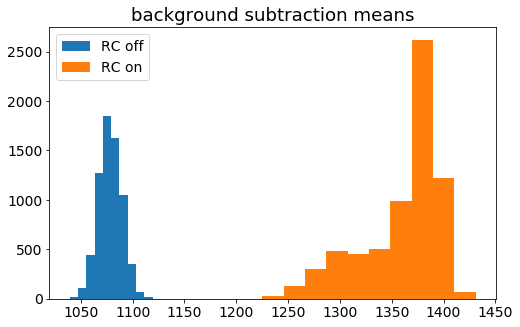

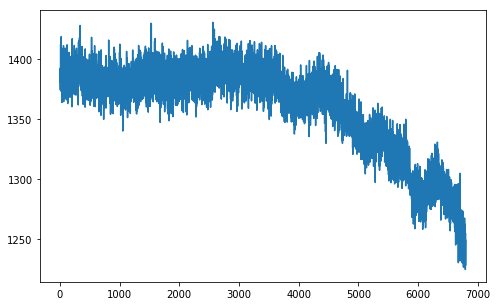

In [680]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(d, bins = 15);
ax.set_title('integrals of empty pmt traces')
set_fontsize(ax, 14)

d1 = norm_data - np.mean(norm_data[:,-3000:], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(d1, bins = 15);
ax.set_title('integrals of empty absorption traces')
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.mean(pmt_data[:,slice_flm], axis = 1)[mask_sh_closed], label = 'RC off');
ax.hist(np.mean(pmt_data[:,slice_flm], axis = 1)[mask_sh_open], label = 'RC on');
ax.legend(fontsize = 14)
ax.set_title('background subtraction means')
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.mean(pmt_data[:,slice_flm], axis = 1)[mask_sh_open])

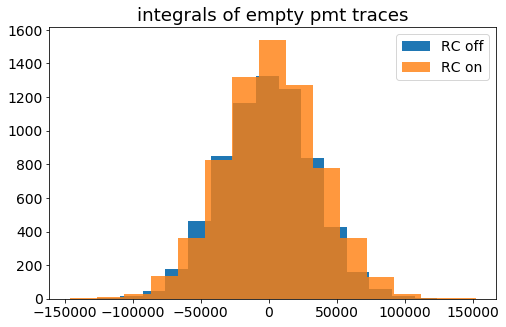

In [681]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
o = np.trapz(d[:,150:], axis = 1)[mask_sh_open]
c = np.trapz(d[:,150:], axis = 1)[mask_sh_closed]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(c, bins = 15, label = 'RC off');
ax.hist(o, bins = 15, label = 'RC on', alpha = 0.8);

ax.legend(fontsize = 14)
ax.set_title('integrals of empty pmt traces')
set_fontsize(ax, 14)

### Fake signals on real empty traces

In [657]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
# mask_sh_open = np.ones(len(shutter_data), dtype = bool)
# mask_sh_open[::2] = False
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 

for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    gain[mask_frequency] *= gaussian(f, 1, 227.5, 2)

fake_data = pmt_data.copy()
fake_data_norm = fake_data - np.mean(fake_data[:,-3000:], axis = 1)[:,np.newaxis]
fake_data_norm = fake_data_norm + (gaussian(_x,1000,800,150)*gain[:,np.newaxis])

In [658]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

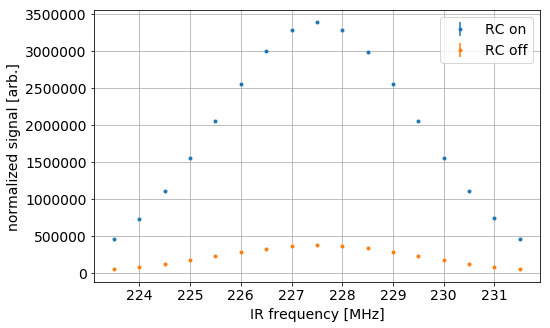

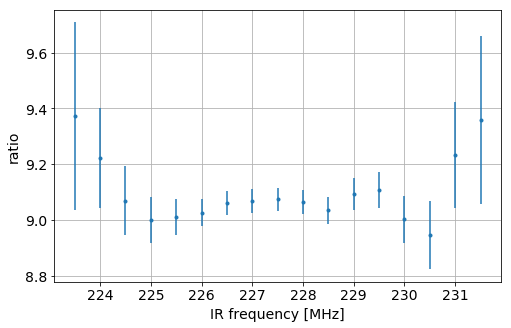

In [659]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [660]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
# mask_sh_open = np.ones(len(shutter_data), dtype = bool)
# mask_sh_open[::2] = False
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 

fake_data = pmt_data + (gaussian(_x,2000,800,150)*gain[:,np.newaxis])
fake_data_norm = fake_data - np.mean(fake_data[:,slice_flm], axis = 1)[:,np.newaxis]

In [661]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

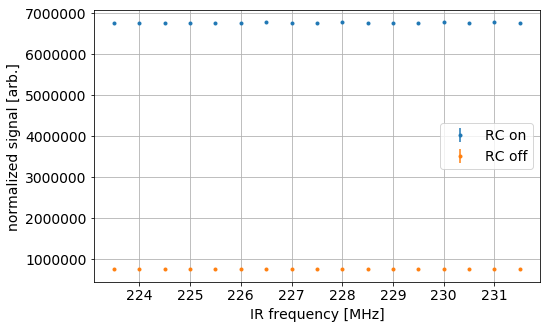

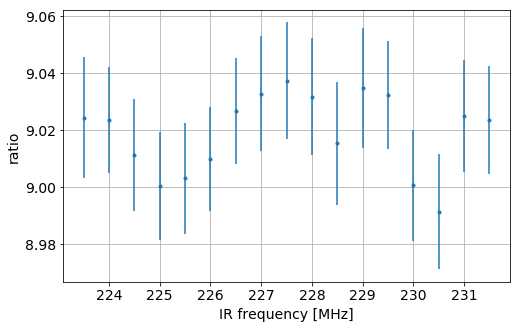

In [662]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan without beam or YAG firing
larger scan range  
PMT on  
RC and DET on  
microwaves on

In [682]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [683]:
dset_idx = 9
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

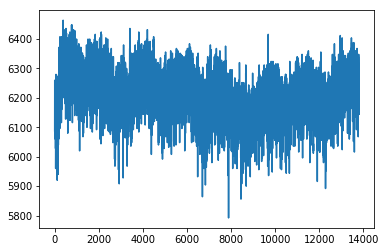

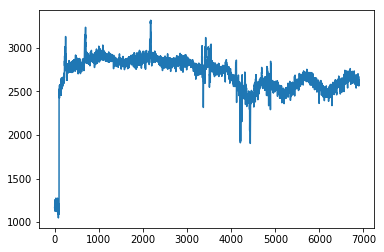

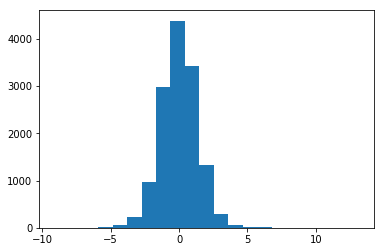

In [684]:
plt.plot(pdn_data.min(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [685]:
yag_cutoff = 250
ptn_cutoff = 5500
abs_cutoff = 3
fl_cutoff = -100000

In [686]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_pdn

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.0% data discarded


In [687]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

traces = []
stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    traces.append(pmt_data_norm[mt])
    dat = (fluorescence_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
traces = traces
bin_means = np.unique(scan_parameters)

224.0 MHz
mean = 489 +/- 1151
nr shots = 900


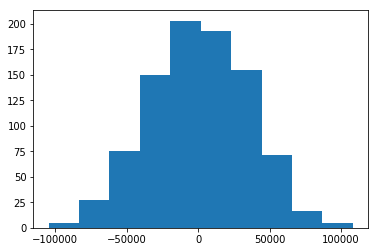

In [688]:
idx = 1
plt.hist(np.trapz(traces[idx][:, slice_fli], axis = 1));
print(f"{bin_means[idx]} MHz")
print(f"mean = {np.trapz(traces[idx][:, slice_fli], axis = 1).mean():.0f} +/- {np.trapz(traces[idx][:, slice_fli], axis = 1).std()/np.sqrt(len(traces[idx])-1):.0f}")
print(f"nr shots = {len(traces[idx])}")

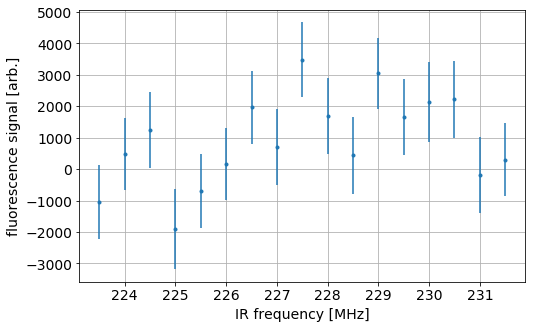

In [689]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('fluorescence signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [692]:
mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

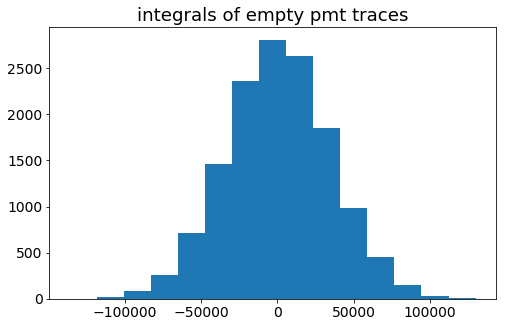

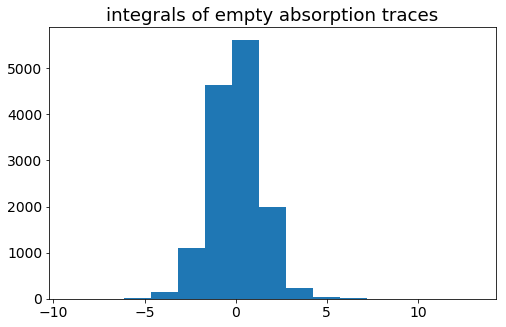

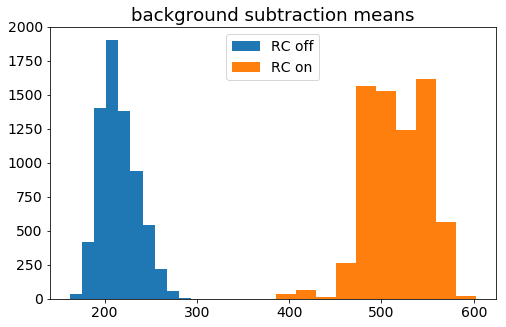

In [693]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
d = np.trapz(d[:,150:], axis = 1)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(d, bins = 15);
ax.set_title('integrals of empty pmt traces')
set_fontsize(ax, 14)

d1 = norm_data - np.mean(norm_data[:,-3000:], axis = 1)[:, np.newaxis]
d1 = np.trapz(d1[:,10:2000], axis = 1)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(d1, bins = 15);
ax.set_title('integrals of empty absorption traces')
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.mean(pmt_data[:,slice_flm], axis = 1)[mask_sh_closed], label = 'RC off');
ax.hist(np.mean(pmt_data[:,slice_flm], axis = 1)[mask_sh_open], label = 'RC on');
ax.legend(fontsize = 14)
ax.set_title('background subtraction means')
set_fontsize(ax, 14)

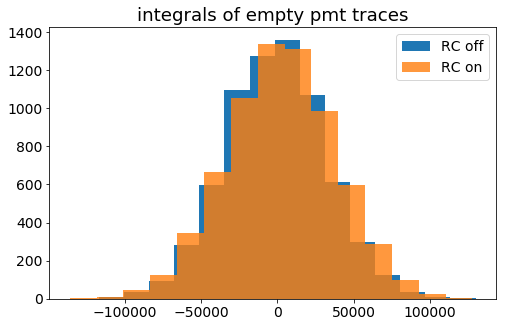

In [694]:
d = pmt_data - np.mean(pmt_data[:,-3000:], axis = 1)[:, np.newaxis]
o = np.trapz(d[:,150:], axis = 1)[mask_sh_open]
c = np.trapz(d[:,150:], axis = 1)[mask_sh_closed]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(c, bins = 15, label = 'RC off');
ax.hist(o, bins = 15, label = 'RC on', alpha = 0.8);

ax.legend(fontsize = 14)
ax.set_title('integrals of empty pmt traces')
set_fontsize(ax, 14)

In [696]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 

for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    gain[mask_frequency] *= gaussian(f, 1, 227.5, 2)

fake_data = pmt_data.copy()
fake_data_norm = fake_data - np.mean(fake_data[:,-3000:], axis = 1)[:,np.newaxis]
fake_data_norm = fake_data_norm + (gaussian(_x,1000,800,150)*gain[:,np.newaxis])

In [697]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

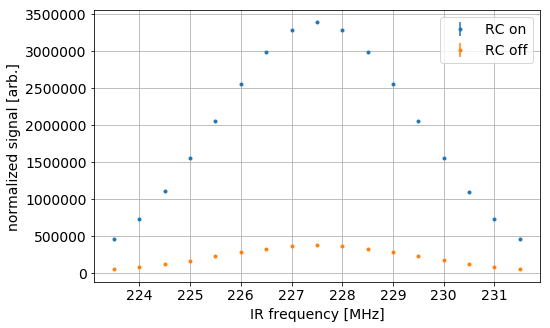

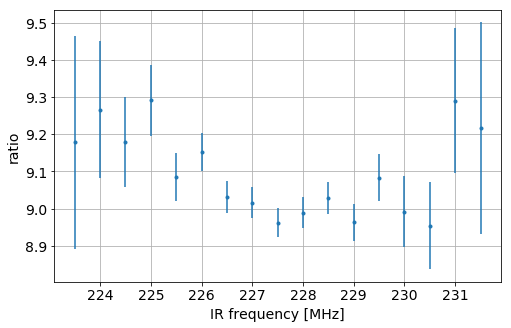

In [698]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [699]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mask_sh_open = shutter_data.max(axis = 1) > 10000
# mask_sh_open = np.ones(len(shutter_data), dtype = bool)
# mask_sh_open[::2] = False
mask_sh_closed = ~mask_sh_open

_x = np.linspace(0,5999,6000)
gain = np.ones(len(pmt_data))
gain[mask_sh_open] = 9 

fake_data = pmt_data + (gaussian(_x,2000,800,150)*gain[:,np.newaxis])
fake_data_norm = fake_data - np.mean(fake_data[:,slice_flm], axis = 1)[:,np.newaxis]

In [700]:
fake_integral = np.trapz(fake_data_norm[:,slice_fli], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = fake_integral[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

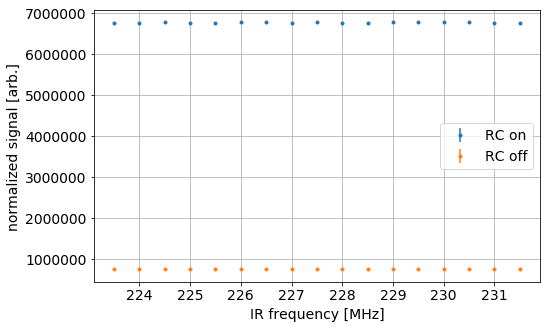

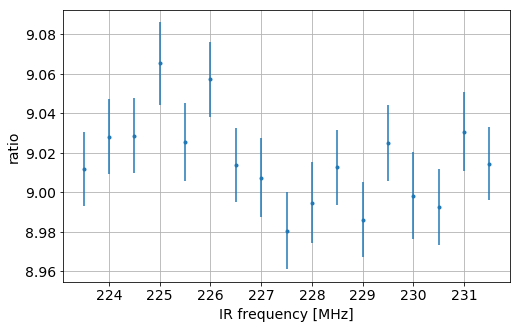

In [701]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)